# Getting Started
 - Shows collision detection
 - Provides a plotting function
 - Creates a slightly optimized submission

In [2]:
import shapely
print(f'Using shapely {shapely.__version__}')

Using shapely 2.1.2


In [3]:
import math
import os
import random
from decimal import Decimal, getcontext

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Rectangle
from shapely import affinity, touches
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely.strtree import STRtree

pd.set_option('display.float_format', '{:.12f}'.format)

# Set precision for Decimal
getcontext().prec = 25
scale_factor = Decimal('1e15')

In [4]:
# Build the index of the submission, in the format:
#  <trees_in_problem>_<tree_index>

index = [f'{n:03d}_{t}' for n in range(1, 201) for t in range(n)]

In [5]:
class ChristmasTree:
    """Represents a single, rotatable Christmas tree of a fixed size."""

    def __init__(self, center_x='0', center_y='0', angle='0'):
        """Initializes the Christmas tree with a specific position and rotation."""
        self.center_x = Decimal(center_x)
        self.center_y = Decimal(center_y)
        self.angle = Decimal(angle)

        trunk_w = Decimal('0.15')
        trunk_h = Decimal('0.2')
        base_w = Decimal('0.7')
        mid_w = Decimal('0.4')
        top_w = Decimal('0.25')
        tip_y = Decimal('0.8')
        tier_1_y = Decimal('0.5')
        tier_2_y = Decimal('0.25')
        base_y = Decimal('0.0')
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon(
            [
                # Start at Tip
                (Decimal('0.0') * scale_factor, tip_y * scale_factor),
                # Right side - Top Tier
                (top_w / Decimal('2') * scale_factor, tier_1_y * scale_factor),
                (top_w / Decimal('4') * scale_factor, tier_1_y * scale_factor),
                # Right side - Middle Tier
                (mid_w / Decimal('2') * scale_factor, tier_2_y * scale_factor),
                (mid_w / Decimal('4') * scale_factor, tier_2_y * scale_factor),
                # Right side - Bottom Tier
                (base_w / Decimal('2') * scale_factor, base_y * scale_factor),
                # Right Trunk
                (trunk_w / Decimal('2') * scale_factor, base_y * scale_factor),
                (trunk_w / Decimal('2') * scale_factor, trunk_bottom_y * scale_factor),
                # Left Trunk
                (-(trunk_w / Decimal('2')) * scale_factor, trunk_bottom_y * scale_factor),
                (-(trunk_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                # Left side - Bottom Tier
                (-(base_w / Decimal('2')) * scale_factor, base_y * scale_factor),
                # Left side - Middle Tier
                (-(mid_w / Decimal('4')) * scale_factor, tier_2_y * scale_factor),
                (-(mid_w / Decimal('2')) * scale_factor, tier_2_y * scale_factor),
                # Left side - Top Tier
                (-(top_w / Decimal('4')) * scale_factor, tier_1_y * scale_factor),
                (-(top_w / Decimal('2')) * scale_factor, tier_1_y * scale_factor),
            ]
        )
        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(rotated,
                                          xoff=float(self.center_x * scale_factor),
                                          yoff=float(self.center_y * scale_factor))

In [6]:
def generate_weighted_angle():
    """
    Generates a random angle with a distribution weighted by abs(sin(2*angle)).
    This helps place more trees in corners, and makes the packing less round.
    """
    while True:
        angle = random.uniform(0, 2 * math.pi)
        if random.uniform(0, 1) < abs(math.sin(2 * angle)):
            return angle

In [7]:
def initialize_trees(num_trees, existing_trees=None):
    """
    This builds a simple, greedy starting configuration, by using the previous n-tree
    placements, and adding more tree for the (n+1)-tree configuration. We place a tree
    fairly far away at a (weighted) random angle, and the bring it closer to the center
    until it overlaps. Then we back it up until it no longer overlaps.

    You can easily modify this code to build each n-tree configuration completely
    from scratch.
    """
    if num_trees == 0:
        return [], Decimal('0')

    if existing_trees is None:
        placed_trees = []
    else:
        placed_trees = list(existing_trees)

    num_to_add = num_trees - len(placed_trees)

    if num_to_add > 0:
        unplaced_trees = [
            ChristmasTree(angle=random.uniform(0, 360)) for _ in range(num_to_add)]
        if not placed_trees:  # Only place the first tree at origin if starting from scratch
            placed_trees.append(unplaced_trees.pop(0))

        for tree_to_place in unplaced_trees:
            placed_polygons = [p.polygon for p in placed_trees]
            tree_index = STRtree(placed_polygons)

            best_px = None
            best_py = None
            min_radius = Decimal('Infinity')

            # This loop tries 10 random starting attempts and keeps the best one
            for _ in range(10):
                # The new tree starts at a position 20 from the center, at a random vector angle.
                angle = generate_weighted_angle()
                vx = Decimal(str(math.cos(angle)))
                vy = Decimal(str(math.sin(angle)))

                # Move towards center along the vector in steps of 0.5 until collision
                radius = Decimal('20.0')
                step_in = Decimal('0.5')

                collision_found = False
                while radius >= 0:
                    px = radius * vx
                    py = radius * vy

                    candidate_poly = affinity.translate(
                        tree_to_place.polygon,
                        xoff=float(px * scale_factor),
                        yoff=float(py * scale_factor))

                    # Looking for nearby objects
                    possible_indices = tree_index.query(candidate_poly)
                    # This is the collision detection step
                    if any((candidate_poly.intersects(placed_polygons[i]) and not
                            candidate_poly.touches(placed_polygons[i]))
                           for i in possible_indices):
                        collision_found = True
                        break
                    radius -= step_in

                # back up in steps of 0.05 until it no longer has a collision.
                if collision_found:
                    step_out = Decimal('0.05')
                    while True:
                        radius += step_out
                        px = radius * vx
                        py = radius * vy

                        candidate_poly = affinity.translate(
                            tree_to_place.polygon,
                            xoff=float(px * scale_factor),
                            yoff=float(py * scale_factor))

                        possible_indices = tree_index.query(candidate_poly)
                        if not any((candidate_poly.intersects(placed_polygons[i]) and not
                                   candidate_poly.touches(placed_polygons[i]))
                                   for i in possible_indices):
                            break
                else:
                    # No collision found even at the center. Place it at the center.
                    radius = Decimal('0')
                    px = Decimal('0')
                    py = Decimal('0')

                if radius < min_radius:
                    min_radius = radius
                    best_px = px
                    best_py = py

            tree_to_place.center_x = best_px
            tree_to_place.center_y = best_py
            tree_to_place.polygon = affinity.translate(
                tree_to_place.polygon,
                xoff=float(tree_to_place.center_x * scale_factor),
                yoff=float(tree_to_place.center_y * scale_factor),
            )
            placed_trees.append(tree_to_place)  # Add the newly placed tree to the list

    all_polygons = [t.polygon for t in placed_trees]
    bounds = unary_union(all_polygons).bounds

    minx = Decimal(bounds[0]) / scale_factor
    miny = Decimal(bounds[1]) / scale_factor
    maxx = Decimal(bounds[2]) / scale_factor
    maxy = Decimal(bounds[3]) / scale_factor

    width = maxx - minx
    height = maxy - miny
    # this forces a square bounding using the largest side
    side_length = max(width, height)

    return placed_trees, side_length

In [8]:
def plot_results(side_length, placed_trees, num_trees):
    """Plots the arrangement of trees and the bounding square."""
    _, ax = plt.subplots(figsize=(6, 6))
    colors = plt.cm.viridis([i / num_trees for i in range(num_trees)])

    all_polygons = [t.polygon for t in placed_trees]
    bounds = unary_union(all_polygons).bounds

    for i, tree in enumerate(placed_trees):
        # Rescale for plotting
        x_scaled, y_scaled = tree.polygon.exterior.xy
        x = [Decimal(val) / scale_factor for val in x_scaled]
        y = [Decimal(val) / scale_factor for val in y_scaled]
        ax.plot(x, y, color=colors[i])
        ax.fill(x, y, alpha=0.5, color=colors[i])

    minx = Decimal(bounds[0]) / scale_factor
    miny = Decimal(bounds[1]) / scale_factor
    maxx = Decimal(bounds[2]) / scale_factor
    maxy = Decimal(bounds[3]) / scale_factor

    width = maxx - minx
    height = maxy - miny

    square_x = minx if width >= height else minx - (side_length - width) / 2
    square_y = miny if height >= width else miny - (side_length - height) / 2
    bounding_square = Rectangle(
        (float(square_x), float(square_y)),
        float(side_length),
        float(side_length),
        fill=False,
        edgecolor='red',
        linewidth=2,
        linestyle='--',
    )
    ax.add_patch(bounding_square)

    padding = 0.5
    ax.set_xlim(
        float(square_x - Decimal(str(padding))),
        float(square_x + side_length + Decimal(str(padding))))
    ax.set_ylim(float(square_y - Decimal(str(padding))),
                float(square_y + side_length + Decimal(str(padding))))
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')
    plt.title(f'{num_trees} Trees: {side_length:.12f}')
    plt.show()
    plt.close()

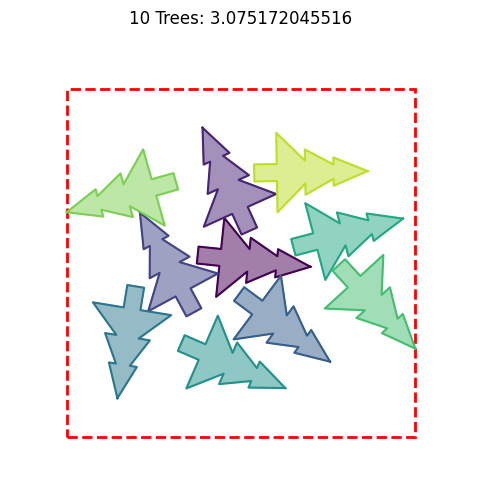

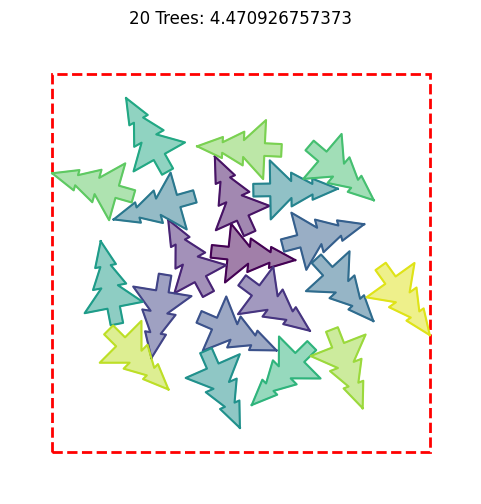

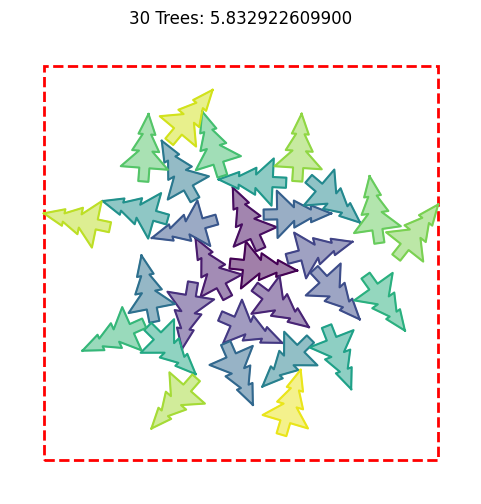

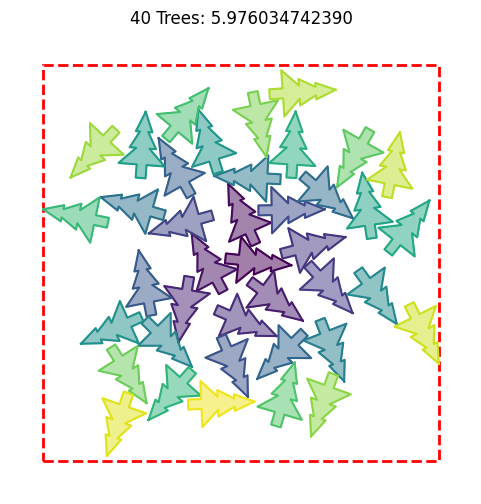

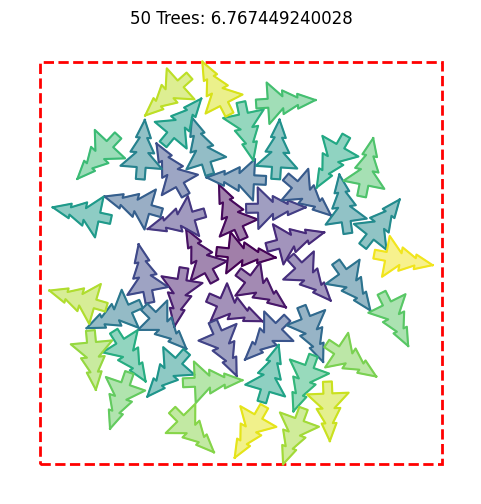

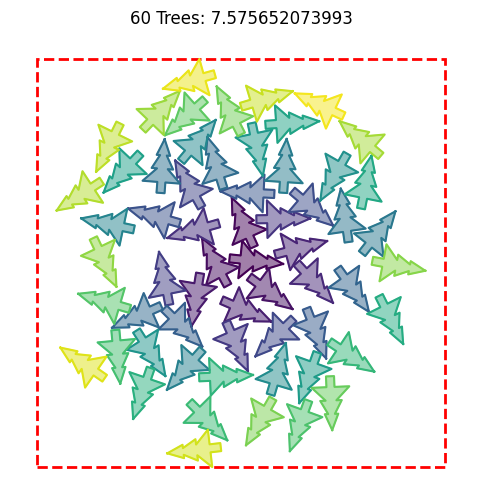

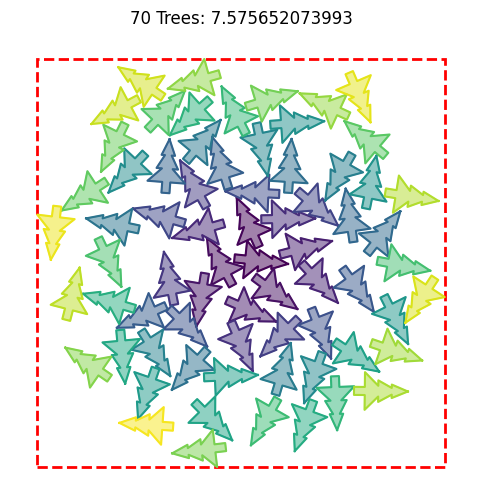

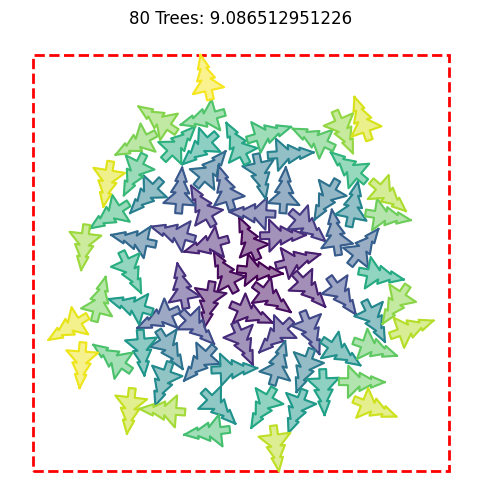

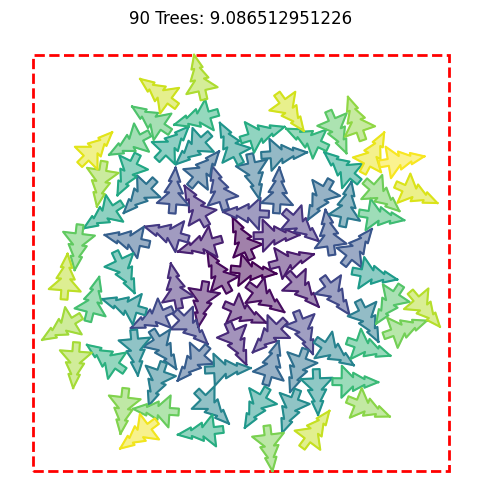

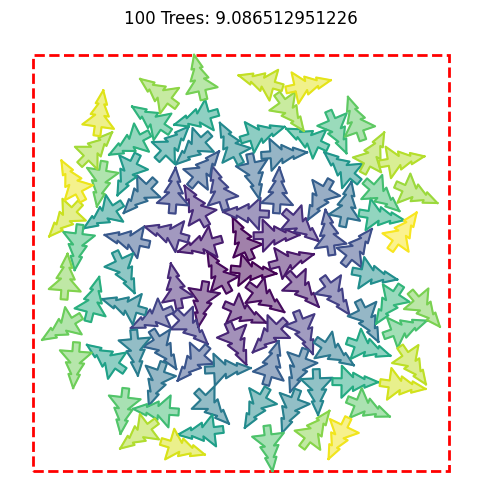

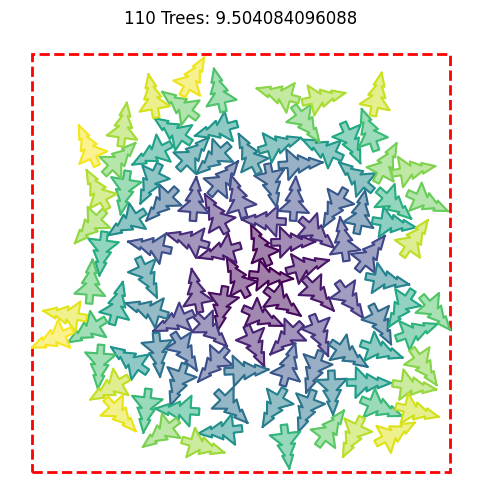

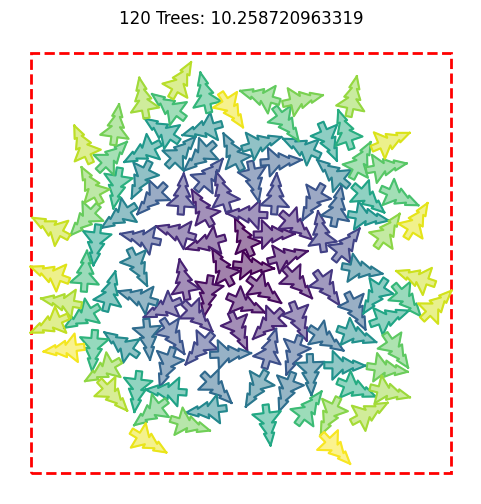

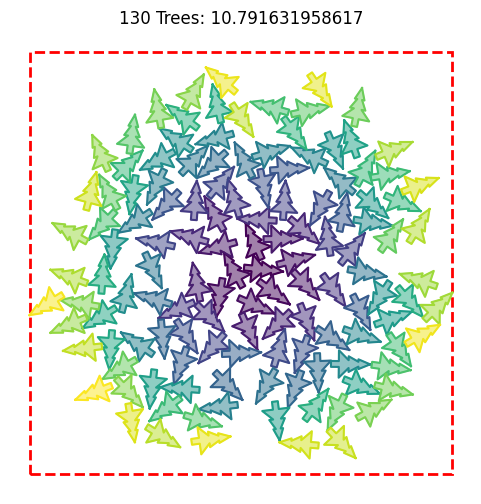

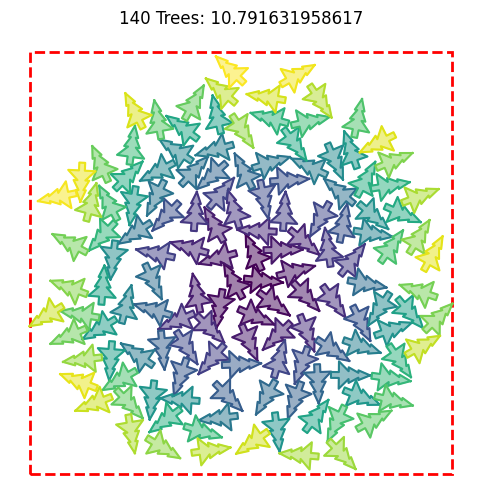

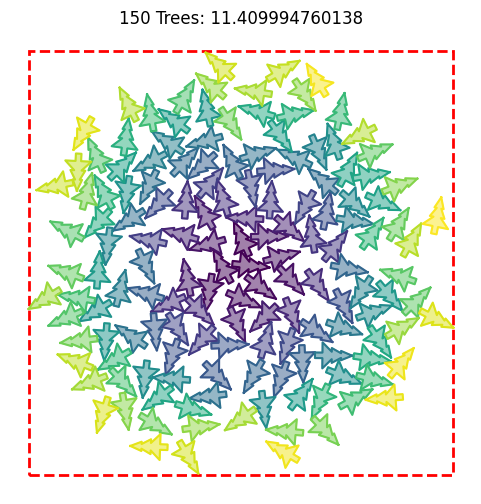

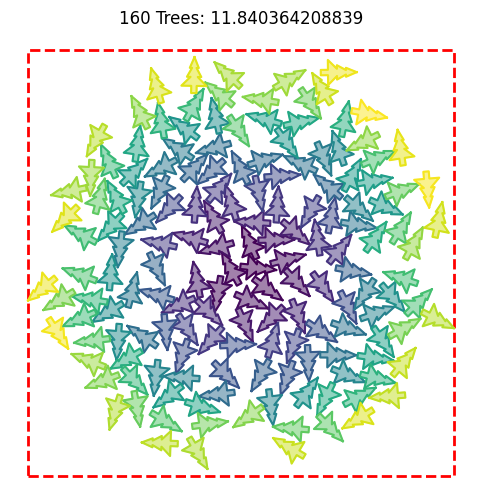

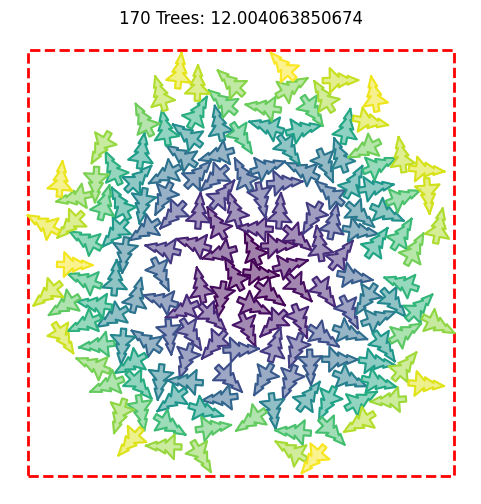

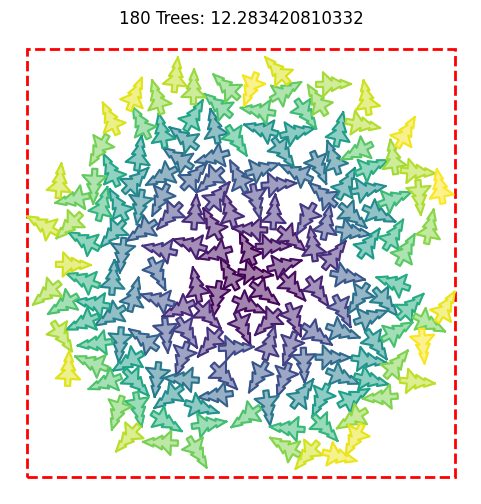

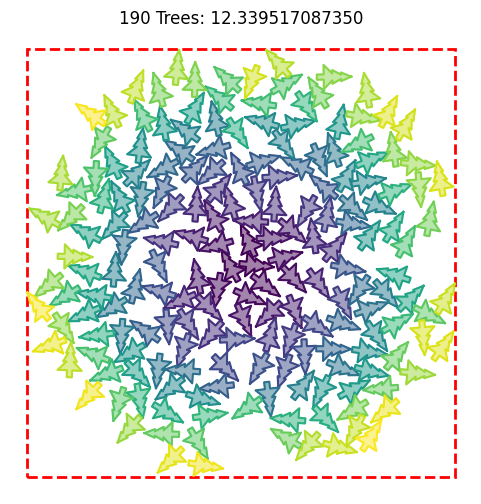

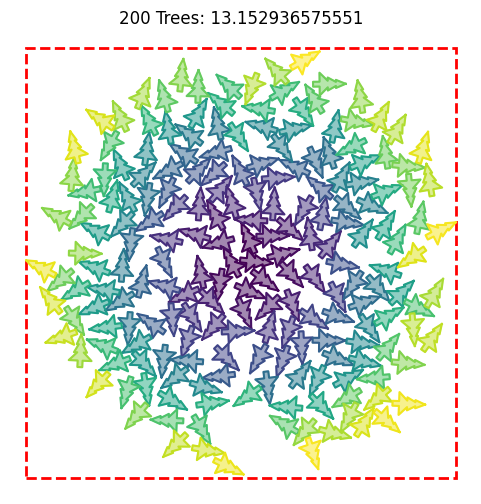

In [9]:
tree_data = []
current_placed_trees = []  # Initialize an empty list for the first iteration

for n in range(200):
    # Pass the current_placed_trees to initialize_trees
    current_placed_trees, side = initialize_trees(n+1, existing_trees=current_placed_trees)
    if (n+1) % 10 == 0:
        plot_results(side, current_placed_trees, n+1)
    for tree in current_placed_trees:
        tree_data.append([tree.center_x, tree.center_y, tree.angle])
        
cols = ['x', 'y', 'deg']
submission = pd.DataFrame(
    index=index, columns=cols, data=tree_data).rename_axis('id')

for col in cols:
    submission[col] = submission[col].astype(float).round(decimals=6)
    
# To ensure everything is kept as a string, prepend an 's'
for col in submission.columns:
    submission[col] = 's' + submission[col].astype('string')
submission.to_csv('sample_submission.csv')

In [10]:
def initialize_trees(
    num_trees,
    existing_trees=None,
    attempts=10,
    start_radius=Decimal('20.0'),
    step_in=Decimal('0.5'),
    step_out=Decimal('0.05'),
    angle_sampler=generate_weighted_angle,
):
    if num_trees == 0:
        return [], Decimal('0')
    placed_trees = [] if existing_trees is None else list(existing_trees)
    num_to_add = num_trees - len(placed_trees)
    if num_to_add > 0:
        unplaced_trees = [ChristmasTree(angle=random.uniform(0, 360)) for _ in range(num_to_add)]
        if not placed_trees:
            placed_trees.append(unplaced_trees.pop(0))
        for tree_to_place in unplaced_trees:
            placed_polygons = [p.polygon for p in placed_trees]
            tree_index = STRtree(placed_polygons)
            best_px = best_py = None
            min_radius = Decimal('Infinity')
            for _ in range(attempts):
                angle = angle_sampler()
                vx = Decimal(str(math.cos(angle)))
                vy = Decimal(str(math.sin(angle)))
                radius = start_radius
                collision_found = False
                while radius >= 0:
                    px = radius * vx
                    py = radius * vy
                    candidate_poly = affinity.translate(tree_to_place.polygon,
                                                        xoff=float(px * scale_factor),
                                                        yoff=float(py * scale_factor))
                    possible = tree_index.query(candidate_poly)
                    if any(candidate_poly.intersects(placed_polygons[i]) and
                           not candidate_poly.touches(placed_polygons[i])
                           for i in possible):
                        collision_found = True
                        break
                    radius -= step_in
                if collision_found:
                    while True:
                        radius += step_out
                        px = radius * vx
                        py = radius * vy
                        candidate_poly = affinity.translate(tree_to_place.polygon,
                                                            xoff=float(px * scale_factor),
                                                            yoff=float(py * scale_factor))
                        possible = tree_index.query(candidate_poly)
                        if not any(candidate_poly.intersects(placed_polygons[i]) and
                                   not candidate_poly.touches(placed_polygons[i])
                                   for i in possible):
                            break
                else:
                    radius = Decimal('0'); px = Decimal('0'); py = Decimal('0')
                if radius < min_radius:
                    min_radius = radius; best_px = px; best_py = py
            tree_to_place.center_x = best_px
            tree_to_place.center_y = best_py
            tree_to_place.polygon = affinity.translate(
                tree_to_place.polygon,
                xoff=float(tree_to_place.center_x * scale_factor),
                yoff=float(tree_to_place.center_y * scale_factor))
            placed_trees.append(tree_to_place)
    all_polygons = [t.polygon for t in placed_trees]
    bounds = unary_union(all_polygons).bounds
    minx, miny, maxx, maxy = [Decimal(v) / scale_factor for v in bounds]
    side_length = max(maxx - minx, maxy - miny)
    return placed_trees, side_length


In [11]:
def run_trial(cfg):
    random.seed(cfg['seed']); np.random.seed(cfg['seed'])
    trees = []
    side = None
    for n in range(200):
        trees, side = initialize_trees(
            n+1,
            existing_trees=trees,
            attempts=cfg['attempts'],
            start_radius=Decimal(str(cfg['start_radius'])),
            step_in=Decimal(str(cfg['step_in'])),
            step_out=Decimal(str(cfg['step_out'])),
            angle_sampler=generate_weighted_angle,
        )
    return side, trees

configs = [
    {'name': 'baseline', 'attempts': 10, 'start_radius': 20.0, 'step_in': 0.5, 'step_out': 0.05, 'seed': 1},
    {'name': 'finer_steps', 'attempts': 10, 'start_radius': 12.0, 'step_in': 0.25, 'step_out': 0.02, 'seed': 1},
    {'name': 'more_attempts', 'attempts': 25, 'start_radius': 12.0, 'step_in': 0.25, 'step_out': 0.02, 'seed': 2},
    {'name': 'tiny_steps', 'attempts': 25, 'start_radius': 8.0,  'step_in': 0.15, 'step_out': 0.01, 'seed': 3},
]

results = []
for cfg in configs:
    side, _ = run_trial(cfg)
    print(f"{cfg['name']}: side={side:.12f}")
    results.append((side, cfg['name'], cfg))

best_side, best_name, best_cfg = min(results, key=lambda r: r[0])
print(f"Best: {best_name} with side {best_side:.12f}")


baseline: side=12.849895831722
finer_steps: side=13.043837786316
more_attempts: side=12.259263338490
tiny_steps: side=12.528990671869
Best: more_attempts with side 12.259263338490


In [13]:
# ids for all puzzles
index = [f'{n:03d}_{t}' for n in range(1, 201) for t in range(n)]

cfg = {'attempts': 25, 'start_radius': 12.0, 'step_in': 0.25, 'step_out': 0.02, 'seed': 2}
random.seed(cfg['seed']); np.random.seed(cfg['seed'])

tree_data = []
current_placed_trees = []
final_side = None

for n in range(200):
    current_placed_trees, final_side = initialize_trees(
        n + 1,
        existing_trees=current_placed_trees,
        attempts=cfg['attempts'],
        start_radius=Decimal(str(cfg['start_radius'])),
        step_in=Decimal(str(cfg['step_in'])),
        step_out=Decimal(str(cfg['step_out'])),
        angle_sampler=generate_weighted_angle,
    )
    # append all placements for this n to the submission list
    for tree in current_placed_trees:
        tree_data.append([tree.center_x, tree.center_y, tree.angle])

print(f"Rows collected: {len(tree_data)}")  # should be 20100
print(f"Final side (200 trees): {final_side:.12f}")

cols = ['x', 'y', 'deg']
submission = pd.DataFrame(tree_data, index=index, columns=cols).rename_axis('id')
for col in cols:
    submission[col] = submission[col].astype(float).round(6)
for col in submission.columns:
    submission[col] = 's' + submission[col].astype('string')

submission.to_csv('sample_submission.csv')


Rows collected: 20100
Final side (200 trees): 12.259263338490


In [ ]:
import itertools, random, math, sys
from decimal import Decimal

# Stronger corner bias than abs(sin(2θ))
def angle_sampler():
    while True:
        a = random.uniform(0, 2 * math.pi)
        if random.random() < abs(math.sin(2 * a)) ** 1.5:
            return a

# Small local search on the last-placed tree
def jiggle_last_tree(trees, current_side):
    deltas = [Decimal(str(d)) for d in (-0.05, -0.02, -0.01, 0.0, 0.01, 0.02, 0.05)]
    rotations = [Decimal(str(r)) for r in (-4, -2, 0, 2, 4)]
    last = trees[-1]
    others = trees[:-1]
    best_side = current_side
    best_poly = last.polygon
    best_pos = (last.center_x, last.center_y, last.angle)
    other_polys = [t.polygon for t in others]
    tree_index = STRtree(other_polys)
    for dx in deltas:
        for dy in deltas:
            for drot in rotations:
                cand = affinity.translate(last.polygon, xoff=float(dx * scale_factor), yoff=float(dy * scale_factor))
                if drot != 0:
                    cand = affinity.rotate(cand, float(drot), origin='centroid')
                if other_polys:
                    possible = tree_index.query(cand)
                    if any(cand.intersects(other_polys[i]) and not cand.touches(other_polys[i]) for i in possible):
                        continue
                polys = other_polys + [cand]
                bounds = unary_union(polys).bounds
                side_len = max(Decimal(str(bounds[2] - bounds[0])), Decimal(str(bounds[3] - bounds[1]))) / scale_factor
                if side_len < best_side:
                    best_side = side_len
                    best_poly = cand
                    best_pos = (last.center_x + dx, last.center_y + dy, last.angle + drot)
    last.center_x, last.center_y, last.angle = best_pos
    last.polygon = best_poly
    return best_side

def run_trial(cfg, verbose_every=5):
    random.seed(cfg['seed']); np.random.seed(cfg['seed'])
    trees = []
    sides = []
    all_positions = []
    for n in range(200):
        trees, side = initialize_trees(
            n + 1,
            existing_trees=trees,
            attempts=cfg['attempts'],
            start_radius=Decimal(str(cfg['start_radius'])),
            step_in=Decimal(str(cfg['step_in'])),
            step_out=Decimal(str(cfg['step_out'])),
            angle_sampler=angle_sampler,
        )
        side = jiggle_last_tree(trees, side)
        polys = [t.polygon for t in trees]
        bounds = unary_union(polys).bounds
        side = max(Decimal(str(bounds[2] - bounds[0])), Decimal(str(bounds[3] - bounds[1]))) / scale_factor
        sides.append(side)
        for t in trees:
            all_positions.append((t.center_x, t.center_y, t.angle))
        if verbose_every and (n + 1) % verbose_every == 0:
            partial_score = sum((s ** 2) / (i + 1) for i, s in enumerate(sides))
            print(f"  n={n+1:3d} side={side:.12f} partial_score={partial_score:.9f}", flush=True)
    score = sum((s ** 2) / (i + 1) for i, s in enumerate(sides))
    return score, sides, all_positions

configs = []
for attempts, sr, si, so, seed in itertools.product(
    [25, 35, 45],
    [9.0, 10.0, 12.0],
    [0.15, 0.20],
    [0.01, 0.015],
    [1, 2, 3],
):
    configs.append({
        'attempts': attempts,
        'start_radius': sr,
        'step_in': si,
        'step_out': so,
        'seed': seed,
    })

best = None
for cfg in configs:
    print(f"\nRunning cfg={cfg}", flush=True)
    score, sides, positions = run_trial(cfg, verbose_every=5)  # adjust frequency if desired
    print(f"cfg={cfg} -> score={score:.9f}, s200={sides[-1]:.12f}", flush=True)
    if (best is None) or (score < best['score']):
        best = {'score': score, 'sides': sides, 'positions': positions, 'cfg': cfg}

print("\nBest config:", best['cfg'], flush=True)
print(f"Best score: {best['score']:.9f} | s200={best['sides'][-1]:.12f}", flush=True)
print(f"Rows collected: {len(best['positions'])}", flush=True)

# Build submission (20,100 rows)
cols = ['x', 'y', 'deg']
submission = pd.DataFrame(best['positions'], index=index, columns=cols).rename_axis('id')
for col in cols:
    submission[col] = submission[col].astype(float).round(6)
for col in submission.columns:
    submission[col] = 's' + submission[col].astype('string')
submission.to_csv('sample_submission.csv')



Running cfg={'attempts': 25, 'start_radius': 9.0, 'step_in': 0.15, 'step_out': 0.01, 'seed': 1}
  n=  5 side=2.424528901085 partial_score=5.413420576
  n= 10 side=2.815241360850 partial_score=10.189247067
  n= 15 side=4.203871413125 partial_score=14.735885302
  n= 20 side=4.203871413125 partial_score=19.675547253
  n= 25 side=4.427204629919 partial_score=23.818315582
  n= 30 side=4.692153859249 partial_score=27.752519280
  n= 35 side=5.224999624123 partial_score=31.719262603
  n= 40 side=5.602449274743 partial_score=35.514201323
  n= 45 side=5.885768510012 partial_score=39.389855329
  n= 50 side=6.479913884275 partial_score=43.649583642
  n= 55 side=6.880570676169 partial_score=47.727156290
  n= 60 side=7.251897537943 partial_score=51.898276603
  n= 65 side=7.251897537943 partial_score=56.074192556
  n= 70 side=7.461717942531 partial_score=60.031624777
  n= 75 side=7.461717942531 partial_score=63.846566142
  n= 80 side=7.905557235847 partial_score=67.764410608
  n= 85 side=8.122890699

KeyboardInterrupt: 

In [19]:
import itertools, random, math, sys
from decimal import Decimal

def angle_sampler():
    while True:
        a = random.uniform(0, 2 * math.pi)
        if random.random() < abs(math.sin(2 * a)) ** 2.0:  # stronger corner bias
            return a

def jiggle_all(trees, current_side, passes=2):
    deltas = [Decimal(str(d)) for d in (-0.05, -0.03, -0.015, 0, 0.015, 0.03, 0.05)]
    rotations = [Decimal(str(r)) for r in (-6, -3, 0, 3, 6)]
    for _ in range(passes):
        improved = False
        polys = [t.polygon for t in trees]
        tree_index = STRtree(polys)
        for idx, tree in enumerate(trees):
            others = polys[:idx] + polys[idx+1:]
            other_idx = STRtree(others) if others else None
            best_poly = polys[idx]
            best_pos = (tree.center_x, tree.center_y, tree.angle)
            best_side = current_side
            for dx in deltas:
                for dy in deltas:
                    for drot in rotations:
                        cand = affinity.translate(tree.polygon,
                                                  xoff=float(dx * scale_factor),
                                                  yoff=float(dy * scale_factor))
                        if drot != 0:
                            cand = affinity.rotate(cand, float(drot), origin='centroid')
                        if other_idx:
                            possible = other_idx.query(cand)
                            if any(cand.intersects(others[i]) and not cand.touches(others[i]) for i in possible):
                                continue
                        candidate_polys = others + [cand]
                        bounds = unary_union(candidate_polys).bounds
                        side_len = max(Decimal(str(bounds[2] - bounds[0])),
                                       Decimal(str(bounds[3] - bounds[1]))) / scale_factor
                        if side_len < best_side:
                            best_side = side_len
                            best_poly = cand
                            best_pos = (tree.center_x + dx, tree.center_y + dy, tree.angle + drot)
            if best_poly is not polys[idx]:
                tree.center_x, tree.center_y, tree.angle = best_pos
                tree.polygon = best_poly
                polys[idx] = best_poly
                improved = True
                current_side = best_side
        if not improved:
            break
    return current_side

def pack_n5(cfg):
    random.seed(cfg['seed']); np.random.seed(cfg['seed'])
    trees = []
    for k in range(5):
        trees, side = initialize_trees(
            k+1,
            existing_trees=trees,
            attempts=cfg['attempts'],
            start_radius=Decimal(str(cfg['start_radius'])),
            step_in=Decimal(str(cfg['step_in'])),
            step_out=Decimal(str(cfg['step_out'])),
            angle_sampler=angle_sampler,
        )
    # global jiggle over all trees
    side = jiggle_all(trees, side, passes=3)
    polys = [t.polygon for t in trees]
    bounds = unary_union(polys).bounds
    side = max(Decimal(str(bounds[2] - bounds[0])),
               Decimal(str(bounds[3] - bounds[1]))) / scale_factor
    return side, trees

# Search settings: widen as needed
configs = []
for attempts, sr, si, so, seed in itertools.product(
    [60, 100, 140],       # more attempts per tree
    [4.0, 6.0, 8.0],      # start radius
    [0.05, 0.08, 0.12],   # step_in
    [0.004, 0.006, 0.008],# step_out
    range(1, 11)          # seeds
):
    configs.append({
        'attempts': attempts,
        'start_radius': sr,
        'step_in': si,
        'step_out': so,
        'seed': seed,
    })

best = None
for cfg in configs:
    s5, trees = pack_n5(cfg)
    print(f"cfg={cfg} s5={s5:.6f}", flush=True)
    if s5 < Decimal('1.5'):
        best = (s5, cfg, trees)
        print(f"  HIT target: s5={s5:.6f}", flush=True)
        break
    if (best is None) or (s5 < best[0]):
        best = (s5, cfg, trees)

print("\nBest found:", best[1], "s5=", best[0])


cfg={'attempts': 60, 'start_radius': 4.0, 'step_in': 0.05, 'step_out': 0.004, 'seed': 1} s5=1.952131
cfg={'attempts': 60, 'start_radius': 4.0, 'step_in': 0.05, 'step_out': 0.004, 'seed': 2} s5=1.797043
cfg={'attempts': 60, 'start_radius': 4.0, 'step_in': 0.05, 'step_out': 0.004, 'seed': 3} s5=1.908256
cfg={'attempts': 60, 'start_radius': 4.0, 'step_in': 0.05, 'step_out': 0.004, 'seed': 4} s5=2.136700
cfg={'attempts': 60, 'start_radius': 4.0, 'step_in': 0.05, 'step_out': 0.004, 'seed': 5} s5=2.270982
cfg={'attempts': 60, 'start_radius': 4.0, 'step_in': 0.05, 'step_out': 0.004, 'seed': 6} s5=2.025496
cfg={'attempts': 60, 'start_radius': 4.0, 'step_in': 0.05, 'step_out': 0.004, 'seed': 7} s5=2.092475
cfg={'attempts': 60, 'start_radius': 4.0, 'step_in': 0.05, 'step_out': 0.004, 'seed': 8} s5=2.017526
cfg={'attempts': 60, 'start_radius': 4.0, 'step_in': 0.05, 'step_out': 0.004, 'seed': 9} s5=1.959276
cfg={'attempts': 60, 'start_radius': 4.0, 'step_in': 0.05, 'step_out': 0.004, 'seed': 10} s

KeyboardInterrupt: 

In [20]:
import itertools, random, math, sys
from decimal import Decimal

# stronger corner bias
def angle_sampler():
    while True:
        a = random.uniform(0, 2 * math.pi)
        if random.random() < abs(math.sin(2 * a)) ** 2.0:
            return a

# small local search on the last-placed tree
def jiggle_last_tree(trees, current_side):
    deltas = [Decimal(str(d)) for d in (-0.05, -0.02, -0.01, 0, 0.01, 0.02, 0.05)]
    rotations = [Decimal(str(r)) for r in (-4, -2, 0, 2, 4)]
    last = trees[-1]
    others = trees[:-1]
    best_side = current_side
    best_poly = last.polygon
    best_pos = (last.center_x, last.center_y, last.angle)
    other_polys = [t.polygon for t in others]
    tree_index = STRtree(other_polys)
    for dx in deltas:
        for dy in deltas:
            for drot in rotations:
                cand = affinity.translate(last.polygon, xoff=float(dx * scale_factor), yoff=float(dy * scale_factor))
                if drot != 0:
                    cand = affinity.rotate(cand, float(drot), origin='centroid')
                if other_polys:
                    possible = tree_index.query(cand)
                    if any(cand.intersects(other_polys[i]) and not cand.touches(other_polys[i]) for i in possible):
                        continue
                polys = other_polys + [cand]
                bounds = unary_union(polys).bounds
                side_len = max(Decimal(str(bounds[2] - bounds[0])), Decimal(str(bounds[3] - bounds[1]))) / scale_factor
                if side_len < best_side:
                    best_side = side_len
                    best_poly = cand
                    best_pos = (last.center_x + dx, last.center_y + dy, last.angle + drot)
    last.center_x, last.center_y, last.angle = best_pos
    last.polygon = best_poly
    return best_side

def pack_100(seed, params):
    random.seed(seed); np.random.seed(seed)
    trees = []
    side = None
    for n in range(100):
        trees, side = initialize_trees(
            n + 1,
            existing_trees=trees,
            attempts=params['attempts'],
            start_radius=Decimal(str(params['start_radius'])),
            step_in=Decimal(str(params['step_in'])),
            step_out=Decimal(str(params['step_out'])),
            angle_sampler=angle_sampler,
        )
        side = jiggle_last_tree(trees, side)
        polys = [t.polygon for t in trees]
        bounds = unary_union(polys).bounds
        side = max(Decimal(str(bounds[2] - bounds[0])), Decimal(str(bounds[3] - bounds[1]))) / scale_factor
    return side, trees

# search settings
base_params = {
    'attempts': 100,
    'start_radius': 4.0,
    'step_in': 0.05,
    'step_out': 0.004,
}
target_side = Decimal('5.30')   # start guess
side_step = Decimal('0.10')     # increment if it doesn’t fit
max_side_steps = 10
seeds = list(range(1, 11))      # 10 attempts per side

best = None
found = None

for step in range(max_side_steps):
    ts = target_side + side_step * step
    print(f"\nTrying target side {ts}")
    for seed in seeds:
        side, trees = pack_100(seed, base_params)
        print(f"  seed={seed:2d} -> side={side:.6f}", flush=True)
        if (best is None) or (side < best[0]):
            best = (side, seed, ts, trees)
        if side <= ts:
            found = (side, seed, ts, trees)
            print(f"  SUCCESS at seed {seed} with side {side:.6f} <= target {ts}", flush=True)
            break
    if found:
        break

if found:
    print(f"\nBest fitting run: seed={found[1]}, target={found[2]}, side={found[0]:.6f}")
else:
    print("\nNo fit under the tested targets. Best so far:")
    print(f"  side={best[0]:.6f} (seed={best[1]}, target tried={best[2]})")

# If you want to inspect the best placement for 100 trees:
# best_trees = (found or best)[3]
# plot_results((found or best)[0], best_trees, 100)



Trying target side 5.30
  seed= 1 -> side=8.915868
  seed= 2 -> side=8.510314
  seed= 3 -> side=8.526423


KeyboardInterrupt: 

In [21]:
from decimal import Decimal
from shapely.ops import unary_union

def ten_by_ten_layout():
    spacing_x = Decimal('0.7')   # tree width is ~0.7
    spacing_y = Decimal('1.0')   # tree height is ~1.0 (−0.2..0.8)
    trees = []
    for i in range(100):
        r, c = divmod(i, 10)
        cx = spacing_x * c
        cy = spacing_y * r
        trees.append(ChristmasTree(center_x=str(cx), center_y=str(cy), angle='0'))
    # bounding square side
    polys = [t.polygon for t in trees]
    bounds = unary_union(polys).bounds
    side = max(Decimal(str(bounds[2] - bounds[0])), Decimal(str(bounds[3] - bounds[1]))) / scale_factor
    return side, trees

side, trees = ten_by_ten_layout()
print(f"10x10 grid side: {side:.6f}")  # ≈ 10.0


10x10 grid side: 10.000000


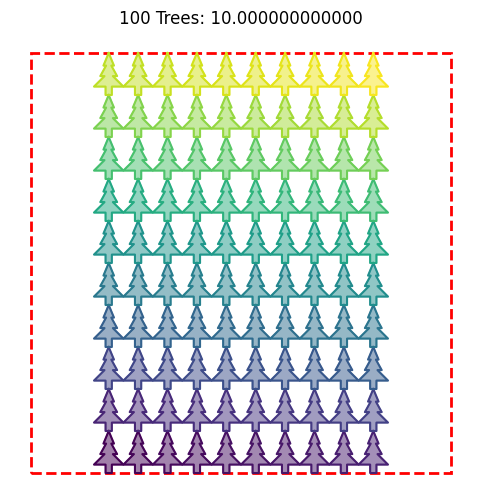

In [22]:
plot_results(side, trees, num_trees=100)


72 trees side: 7.280000000000


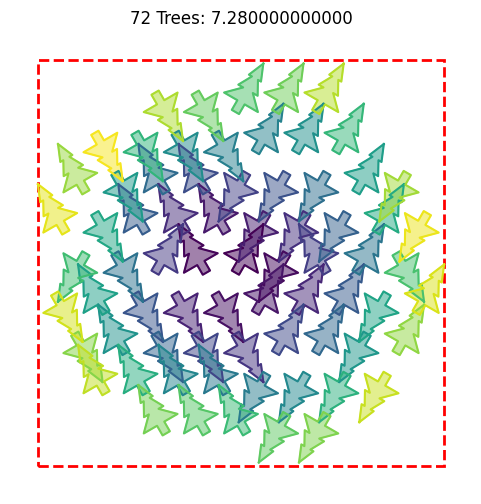

In [23]:
import math
from decimal import Decimal
from shapely.ops import unary_union

def hex_positions(num, dx=Decimal('0.72'), dy=Decimal('0.72')):
    # hex grid centered at 0, sorted by radius
    span = int(math.ceil(math.sqrt(num))) + 3
    pts = []
    for r in range(-span, span + 1):
        y = dy * Decimal(r)
        for c in range(-span, span + 1):
            x = dx * (Decimal(c) + Decimal('0.5') * (r & 1))
            pts.append((x, y))
    pts.sort(key=lambda p: float(p[0] ** 2 + p[1] ** 2))
    return pts[:num]

def pack_rotated_lattice(num_trees=72,
                         dx=Decimal('0.72'),
                         dy=Decimal('0.72'),
                         angles=(Decimal('-30'), Decimal('30'), Decimal('150'), Decimal('-150')),
                         offsets=(Decimal('0'), Decimal('0.03'), Decimal('0.06'))):
    positions = hex_positions(num_trees, dx=dx, dy=dy)
    placed = []

    for i, (cx, cy) in enumerate(positions):
        base_ang = angles[i % len(angles)]
        placed_polys = [t.polygon for t in placed]
        tree_index = STRtree(placed_polys) if placed_polys else None

        found = None
        # small offset grid to resolve collisions
        for ox in offsets:
            for sx in (-1, 1):
                for oy in offsets:
                    for sy in (-1, 1):
                        x = cx + sx * ox
                        y = cy + sy * oy
                        t = ChristmasTree(center_x=str(x), center_y=str(y), angle=str(base_ang))
                        poly = t.polygon
                        if tree_index:
                            possible = tree_index.query(poly)
                            if any(poly.intersects(placed_polys[k]) and not poly.touches(placed_polys[k])
                                   for k in possible):
                                continue
                        found = t
                        break
                    if found:
                        break
                if found:
                    break
            if found:
                break

        if found is None:
            # last-resort: drop it without offset (likely overlaps)
            found = ChristmasTree(center_x=str(cx), center_y=str(cy), angle=str(base_ang))
        placed.append(found)

    # bounding square side
    bounds = unary_union([t.polygon for t in placed]).bounds
    side = max(Decimal(str(bounds[2] - bounds[0])), Decimal(str(bounds[3] - bounds[1]))) / scale_factor
    return side, placed

# Example: 72 trees
side, trees = pack_rotated_lattice(num_trees=72)
print(f"72 trees side: {side:.12f}")
plot_results(side, trees, num_trees=72)
